
# Constructing A Neural Network To Classify Knives from a Texas Government Surplus Store

## Categorizing Nine Different Knives as Profitable or Not Profitable using a CNN for Knife Images and a RNN for Titles from Ebay Listings 

**Author:** Dylan Dey
***

# Overview
[Texas State Surplus Store](https://www.tfc.texas.gov/divisions/supportserv/prog/statesurplus/)

[What happens to all those items that get confiscated by the TSA? Some end up in a Texas store.](https://www.wfaa.com/article/news/local/what-happens-to-all-those-items-that-get-confiscated-by-the-tsa-some-end-up-in-a-texas-store/287-ba80dac3-d91a-4b28-952a-0aaf4f69ff95)

[Texas Surplus Store PDF](https://www.tfc.texas.gov/divisions/supportserv/prog/statesurplus/State%20Surplus%20Brochure-one%20bar_rev%201-10-2022.pdf)

![Texas State Surplus Store](https://encrypted-tbn0.gstatic.com/images?q=tbn:ANd9GcRYkwyu20VBuQ52PrXdVRaGRIIg9OPXJg86lA&usqp=CAU)

![Texas Knives In Stores](https://arc-anglerfish-arc2-prod-bostonglobe.s3.amazonaws.com/public/MWJCCFBSR4I6FCSNKONTFJIRAI.jpg)

[Everything that doesn't make it through Texas airports can be found at one Austin store](https://cbsaustin.com/news/local/everything-that-doesnt-make-it-through-texas-airports-can-be-found-at-one-austin-store)


> The Texas Facilities Commission collects left behind possessions, salvage, and surplus from Texas state agencies such as DPS, TXDOT, TCEQ, and Texas Parks & Wildlife. Examples of commonly available items include vehicles, furniture, office equipment and supplies, small electronics, and heavy equipment. The goal of this project is to create a Neural Network Classification Model in order to categorize knives available at this store as either profitable or not on ebay. 

# Business Problem

[Family Ebay Store Front](https://www.ebay.com/str/texasdave3?mkcid=16&mkevt=1&mkrid=711-127632-2357-0&ssspo=ZW3G27tGR_m&sssrc=3418065&ssuid=&widget_ver=artemis&media=COPY)

![Father's Ebay Account Since 1999](texas_dave.jpg)

[Texas Dave's Knives](https://www.ebay.com/str/texasdave3/Knives/_i.html?store_cat=3393246519)


> While taking online courses to transition careers during a difficult time of my life, I was also helping my family during a turbulent time for everyone. I have been employed at their retail store in San Antonio for the past several months and have been contributing significantly to their online reselling business on eBay. I would help source newer, cheaper products from Austin to try and resell at the retail store in San Antonio or online to earn some money, support our family business and keep us all afloat. This is how I discovered the Texas Facillities Retail Store. 


> My family has been running a resale shop and selling on Ebay and other sites for years and lately the business has picked up.  Consumer behavior is shifting:  getting a deal on eBay, or Goodwill, or hitting up a vintage boutique shop to find a unique treasure is now brag worthy.  Plus, people like the idea of sustainability - sending items to landfills is becoming very socially unacceptable – why not repurpose a used item?  With the pandemic related disruption of “normal” business and supply chains and the economic uncertainty of these times there is definitely an upswing in interest in the resale market. 

> Online sales sites like Ebay offer a worldwide robust buyer base for just about every product regardless of condition. Ebay  allows the reseller to find both  bargain hunters for common items and  enthusiasts searching for rare  collectible items. 

> An Ebay business has some pain points, however.  Selection of an item to sell is the main pain point. The item should be readily available in decent condition for the seller to purchase at a low price but not so widely available that the market is saturated with that item.  Then there needs to be a demand for the item – it should be something collectible that with appeal to hobbyists that would pay premium prices for hard-to-get items. Alternatively, it would be something useful to a large number of people even in a used condition. The item should be small enough to be easily shipped. It should not be difficult to ship either—that is it should not have hazardous chemicals, batteries etc. that would add costs to the shipping. Additionally, Ebay has strict rules about authentication and certification in many item categories- so obvious “high value” items like jewelry or designer purses are so restricted that it is not  feasible  for the average Ebay seller  to offer them . 

> This project recommends an item that would answer these concerns – pocket knives, These can be rare and collectible and also practical and useful. There are knife collector forums and subReddits, showing there is an interest among collectors.  A look at eBay listings shows rare knives selling for thousands of 
dollars each.  Knives are also a handy every day tool –  and based on the number  showing up in the Texas Surplus shop they are easy to lose and so need replacing often. This means there is a market for more common ones as well.  The great thing about single blade, modern, factory manufactured pocketknives is that they all weigh roughly 0.5 lbs making them cheap to ship. For my modeling purposes, it is safe to assume a flat shipping rate of 4.95(US Dollars) including the cost of wholesale purchased padded envelopes. And there are no restrictions on mailing these items and they are not frsgile so no special packaging is needed. 

> The second pain point is buying at a cost low enough to make a profit. It is not enough to just buy low and sell at a higher price as expenses need to be considered.  Ebay collects insertion fees and final value fees on all sales.  The fees vary with seller level (rating)  and some portions  are a percent of final sale. I have been selling knives from the lower priced bins and the mean seller fee for my sales so far is about 13.5% of the sold price.  So that is a cost to consider right up front. 

> A third pain point is the cost of excess inventory. A seller can obtain quality items at a reasonable cost and then the inventory may sit with no sales, meaning the capital expended is sitting tied up in unwanted items. This inventory carry cost is a drain on profitability.  This project is meant to help avoid purchasing the wrong items for resale. 


> As already mentioned, I have been experimenting with low cost used knives for resale but have not risked a large capital investment in the higher end items. The goal of this project is to attempt to address the pain points to determine if a larger investment would pay off. Can I identify which knives are worth investing in so that I can turn a decent profit and hopefully avoid excess inventory? A data driven approach would help avoid costly mistakes from the "system" resellers currently employ, which seems to be mainly a gambler’s approach. By managing resources upfront through a model, I can effectively increase my return on investment with messy data such as pictures and titles. The magic of Neural Networks!





















> There are nine buckets of presorted brand knives that I was interested in, specifically. The other buckets are full of unbranded knives that usually are crowded with way too many people. These other bins, however, are behind glass, presorted, branded(and therefore have specific characteristics and logos for my model to identify), and priced higher. 



** knife bucket image ** 




[Ebay Developer Website](https://developer.ebay.com/)
> Ebay has a seperate website for develoers in order to create an account and register an application keyset in order to make API call requests to their live website. By making a findItemsAdvanced call to the eBay Finding APIVersion 1.13.0, I was able to get a large dataset of[category_id=<48818>](https://www.ebay.com/sch/48818/i.html?_from=R40&_nkw=knife) knives.

> When you log into Ebay as a buyer and search knife in the search bar, the response that loads outputs  Knives, Swords & Blades. Nested one category furtheris Collectible Folding Knives with an id of 182981. Nested one further is Modern Folding Knives(43333), and then finally, the category_id of most interest, 48818, Factory Manufactured Modern Collectible Folding Knives.

#











***
Questions to consider:
* What are the business's pain points related to this project?
* How did you pick the data analysis question(s) that you did?
* Why are these questions important from a business perspective?
***





















## Data Understanding

Describe the data being used for this project.
***
Questions to consider:
* Where did the data come from, and how do they relate to the data analysis questions?
* What do the data represent? Who is in the sample and what variables are included?
* What is the target variable?
* What are the properties of the variables you intend to use?
***

In [1]:
import pandas as pd 
import xmltodict, json
import requests
import numpy as np
import re
import preprocess_ddey117 as pp
import matplotlib.pyplot as plt
%matplotlib inline


import seaborn as sns 

# Data Obtainment: eBay Finding APIVersion 1.13.0  "http://www.ebay.com/marketplace/search/v1/services"

```
import xmltodict, json
import requests
import pandas as pd
import numpy as np
import os
from dotenv import load_dotenv
load_dotenv("ebay_api_key.env") #hide production key in environment file



APP_ID = os.getenv("EBAY_PROD_ID")
```
### URL
HTTP call url to send the Production Client API. The Payload will modify the url below with a ? followed by an % and key value pairs. This is the most common and recommended way that ebay suggests users to send a request to the Finding API.

### HTTP Headers
Required headers to return a 200 response code. The top header is AuthnAuth security. As there is no need for a user token and the only interface is with my app, the only security required is for the app. The second row is the call be sent to the Finding API, findItemsAdvanced. ## THIS SHOULD BE A LINK DOG. The third formats the respons as JSON.

### Payload
Modifies HTTP call. Search for knife in the Collectible-Modern-Factory-Manufactured-Folding-Knives that is of the Used Condition. This request returns 100 pages on page 1.


```
url = "https://svcs.ebay.com/services/search/FindingService/v1" #url fir Finding API


headers = {"X-EBAY-SOA-SECURITY-APPNAME": APP_ID, #production client_id
           "X-EBAY-SOA-OPERATION-NAME": "findItemsAdvanced", #call_id
           "X-EBAY-API-RESPONSE-ENCODING": "JSON" #format respons as JSON
          }



payload = {"keywords":"knife", #knife in search bar
           "categoryId":"48818", #Collectible-Modern-Factory-Manufactured-Folding-Knives
          "itemFilter.name":"Condition", #item filter, used condition
          "itemFilter.value":"Used",
          "paginationInput.entriesPerPage":100, #pagination 
          "paginationInput.pageNumber":1
          }
```





### request section
```
r = requests.get(url, headers=headers, params=payload)
json_dict_100knivesp1 = xmltodict.parse(r.text)
knives_data_list_of_dicts = json_dict_100knivesp1['findItemsAdvancedResponse']['searchResult']['item']
total_pages = int(json_dict_100knivesp1['findItemsAdvancedResponse']['paginationOutput']['totalPages'])
```





### Function For Organizing Call Response
```
#create function for organizing API call
def prepare_data(data_list):
    """
    This function takes in a list of dictionaries and prepares it
    for analysis
    """
    
    # Make a new list to hold results
    results = []
    
    for business_data in data_list:
    
        # Make a new dictionary to hold prepared data for this business
        prepared_data = {}
        
        # Extract name, review_count, rating, and price key-value pairs
        # from business_data and add to prepared_data
        # If a key is not present in business_data, add it to prepared_data
        # with an associated value of None
        
        keys = ['itemId', 'title', 'galleryURL', 
        'viewItemURL', 'postalCode', 'location', 
        'country', 'shippingInfo', 'sellingStatus', 
        'listingInfo', 'returnsAccepted', 'condition'
       ]
        
        for key in keys:
            prepared_data[key] = business_data.get(key, None)
    
       
        # Add to list if all values are present
        if all(prepared_data.values()):
            results.append(prepared_data)
    
    return results
```

### Organize Call with Function

```
prepared_knives = prepare_data(knives_data_list_of_dicts)

```

### Paginate and append responses to empty list to get full list of data


```
# Create an empty list for the full prepared dataset
full_dataset = []

for page in range(total_pages):
    # Add or update the "offset" key-value pair in url_params
    payload["paginationInput.pageNumber"] = page
    
    # Make the query and get the response
    response = requests.get(url, headers=headers, params=payload)
    
    # Get the response body in JSON format
    response_json = xmltodict.parse(r.text)
    
    # Get the list of businesses from the response_json
    knives_data_list_of_dicts = response_json['findItemsAdvancedResponse']['searchResult']['item']
    
    # Call the prepare_data function to get a list of processed data
    prepared_knives = prepare_data(knives_data_list_of_dicts)
    
    # Extend full_dataset with this list (don't append, or you'll get
    # a list of lists instead of a flat list)
    full_dataset.extend(prepared_knives)

# Check the length of the full dataset. It will be up to `total`,
# potentially less if there were missing values
display(len(full_dataset))

df = pd.DataFrame(full_dataset)
```


## Pull converted price from nested dictionary

```

#Create row for converted Price of Knives in US dollars
price_list = []
for row in full_dataset:
    price_list.append(row['sellingStatus']['convertedCurrentPrice']['#text'])
    
    
df["price_in_US"] = price_list


df.to_csv("full_datase.csv", index=False)

```

## Data Preparation

Describe and justify the process for preparing the data for analysis.

***
Questions to consider:
* Were there variables you dropped or created?
* How did you address missing values or outliers?
* Why are these choices appropriate given the data and the business problem?
***


# here you run your code to clean the data

```
import code.data_cleaning as dc

full_dataset = dc.full_clean()
```

## Data Modeling
Describe and justify the process for analyzing or modeling the data.

***
Questions to consider:
* How did you analyze or model the data?
* How did you iterate on your initial approach to make it better?
* Why are these choices appropriate given the data and the business problem?
***
# here you run your code to model the data


## Evaluation
Evaluate how well your work solves the stated business problem.

***
Questions to consider:
* How do you interpret the results?
* How well does your model fit your data? How much better is this than your baseline model?
* How confident are you that your results would generalize beyond the data you have?
* How confident are you that this model would benefit the business if put into use?
***


## Conclusions
Provide your conclusions about the work you've done, including any limitations or next steps.

***
Questions to consider:
* What would you recommend the business do as a result of this work?
* What are some reasons why your analysis might not fully solve the business problem?
* What else could you do in the future to improve this project?
***



In [2]:
df = pd.read_csv('data/full_dataset.csv')

In [3]:
df.head()

,itemId,title,galleryURL,viewItemURL,postalCode,location,country,shippingInfo,sellingStatus,listingInfo,returnsAccepted,condition,price_in_US,shipping_cost,converted_price
0,324946521772,Victorinox Classic SD Mini Swiss Army Pocket K...,https://i.ebayimg.com/thumbs/images/g/smEAAOSw...,https://www.ebay.com/itm/Victorinox-Classic-SD...,228**,"Harrisonburg,VA,USA",US,"{'shippingServiceCost': {'@currencyId': 'USD',...","{'currentPrice': {'@currencyId': 'USD', '#text...","{'bestOfferEnabled': 'false', 'buyItNowAvailab...",True,"{'conditionId': '3000', 'conditionDisplayName'...",7.25,3.50,10.75
1,134165340692,CRKT Fossil Folding Knife,https://i.ebayimg.com/thumbs/images/g/uKkAAOSw...,https://www.ebay.com/itm/CRKT-Fossil-Folding-K...,786**,"Kyle,TX,USA",US,"{'shippingServiceCost': {'@currencyId': 'USD',...","{'currentPrice': {'@currencyId': 'USD', '#text...","{'bestOfferEnabled': 'false', 'buyItNowAvailab...",False,"{'conditionId': '3000', 'conditionDisplayName'...",22.99,2.99,25.98
2,233805693414,Victorinox Classic SD Swiss Army Knife 3 Tool ...,https://i.ebayimg.com/thumbs/images/g/3f4AAOSw...,https://www.ebay.com/itm/Victorinox-Classic-SD...,303**,"Atlanta,GA,USA",US,"{'shippingServiceCost': {'@currencyId': 'USD',...","{'currentPrice': {'@currencyId': 'USD', '#text...","{'bestOfferEnabled': 'false', 'buyItNowAvailab...",True,"{'conditionId': '3000', 'conditionDisplayName'...",8.53,0.00,8.53
3,134165290599,CRKT Drifter Folding Knife,https://i.ebayimg.com/thumbs/images/g/u8gAAOSw...,https://www.ebay.com/itm/CRKT-Drifter-Folding-...,786**,"Kyle,TX,USA",US,"{'shippingServiceCost': {'@currencyId': 'USD',...","{'currentPrice': {'@currencyId': 'USD', '#text...","{'bestOfferEnabled': 'false', 'buyItNowAvailab...",False,"{'conditionId': '3000', 'conditionDisplayName'...",16.99,2.99,19.98
4,144636464421,Spyderco Ladybug Lockback Pocket Knife Seki Japan,https://i.ebayimg.com/thumbs/images/g/JowAAOSw...,https://www.ebay.com/itm/Spyderco-Ladybug-Lock...,472**,"North Vernon,IN,USA",US,"{'shippingServiceCost': {'@currencyId': 'USD',...","{'currentPrice': {'@currencyId': 'USD', '#text...","{'bestOfferEnabled': 'true', 'buyItNowAvailabl...",True,"{'conditionId': '3000', 'conditionDisplayName'...",36.00,0.00,36.00


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9646 entries, 0 to 9645
Data columns (total 15 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   itemId           9646 non-null   int64  
 1   title            9646 non-null   object 
 2   galleryURL       9646 non-null   object 
 3   viewItemURL      9646 non-null   object 
 4   postalCode       9646 non-null   object 
 5   location         9646 non-null   object 
 6   country          9646 non-null   object 
 7   shippingInfo     9646 non-null   object 
 8   sellingStatus    9646 non-null   object 
 9   listingInfo      9646 non-null   object 
 10  returnsAccepted  9646 non-null   bool   
 11  condition        9646 non-null   object 
 12  price_in_US      9646 non-null   float64
 13  shipping_cost    9646 non-null   float64
 14  converted_price  9646 non-null   float64
dtypes: bool(1), float64(3), int64(1), object(10)
memory usage: 1.0+ MB


In [5]:
bucket_dict = {'benchmade': 45.0,
               'buck': 20.0,
               'case': 20.0,
               'crkt': 15.0,
               'kershaw': 15.0,
               'leatherman': 30.0, 
               'spyderco': 30.0,
               'victorinox': 20.0
              }

In [6]:
#lowercase titles
df.title = df.title.apply(str.lower)

#remove special characters
df.title.apply(pp.remove_special_chars)
#remove special characters
df.title.apply(pp.remove_special_chars)

test = ' '.join(df['title'].sample(500))
test

'kershaw 3655 volt assisted pocket knife kershaw cinder 1025 folding pocket knife & bottle opener - key chain knife benchmade griptilian 550 pardue design axis sheepsfoot pocket knife kershaw assisted opening cryo 1555ti folding pocket knife (dupont lumivia) crkt lake 111 folding knife victorinox swiss army knife officier suisse 13 blade buck usa vantage 340 small 420hc plain blade folding pocket knife -- good condit crkt drifter folding knife vtg kershaw kai 5100 seki japan 4" gentleman folding lockback pocket knife benchmade usa 484 nakamura m390 pocket knife kershaw chive 1600 knife ken onion assisted opening framelock plain blade usa kershaw 3655 volt assisted pocket knife spyderco ladybug lockback pocket knife seki japan benchmade 417bk folding knife victorinox mauser swiss army knife case usa xx canoe 62131cv folding pocket knife victorinox mauser swiss army knife victorinox mauser swiss army knife kershaw 3871 amplitude assisted folding pocket knife kershaw cinder 1025 folding p

In [7]:
# #REGEX BRAND PATTERNS AFTERN LOWERCASING TITLES AND REMOVING SPEVIAL CHARACTERS


#turn this into a dict bro

# benchmade_pattern = "benchmade"
# buck_pattern = "buck"
# case_pattern = "case"
# crkt_pattern = "crkt"
# kershaw_pattern = "kershaw"
# leatherman_pattern = "leatherman"
# sog_pattern = "sog"
# spyderco_pattern = "spyderco"
# victorinox_pattern = "victorinox"

In [8]:
# df['is_profitable'] = (df['price_in_US'] - df[list(costs.keys())].sum(axis=1))>0

# df.info()



```
df = pd.read_csv("surplusStore/workingDataFrame2.csv")

df.columns

costs = {'benchmade': 45,
         'buck': 20,
         'case': 20,
         'crkt': 15,
         'kershaw': 15,
         'leatherman': 30,
         'sog': 15,
         'spyderco': 30,
         'victorinox': 20,
        }

df['is_profitable'] = (df['price_in_US'] - df[list(costs.keys())].sum(axis=1))>0

df.info()
```



In [9]:
def find_brand(pattern):
    df[pattern] = df.title.apply(lambda x: re.findall(pattern, x.lower()))
    df[pattern] = df[pattern].apply(lambda x: np.nan if len(x)==0 else 1)
    df[pattern].fillna(0, inplace=True)
    return df

In [10]:
for key in list(bucket_dict.keys()):
    find_brand(key)

In [11]:
df.head()

,itemId,title,galleryURL,viewItemURL,postalCode,location,country,shippingInfo,sellingStatus,listingInfo,...,shipping_cost,converted_price,benchmade,buck,case,crkt,kershaw,leatherman,spyderco,victorinox
0,324946521772,victorinox classic sd mini swiss army pocket k...,https://i.ebayimg.com/thumbs/images/g/smEAAOSw...,https://www.ebay.com/itm/Victorinox-Classic-SD...,228**,"Harrisonburg,VA,USA",US,"{'shippingServiceCost': {'@currencyId': 'USD',...","{'currentPrice': {'@currencyId': 'USD', '#text...","{'bestOfferEnabled': 'false', 'buyItNowAvailab...",...,3.50,10.75,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
1,134165340692,crkt fossil folding knife,https://i.ebayimg.com/thumbs/images/g/uKkAAOSw...,https://www.ebay.com/itm/CRKT-Fossil-Folding-K...,786**,"Kyle,TX,USA",US,"{'shippingServiceCost': {'@currencyId': 'USD',...","{'currentPrice': {'@currencyId': 'USD', '#text...","{'bestOfferEnabled': 'false', 'buyItNowAvailab...",...,2.99,25.98,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
2,233805693414,victorinox classic sd swiss army knife 3 tool ...,https://i.ebayimg.com/thumbs/images/g/3f4AAOSw...,https://www.ebay.com/itm/Victorinox-Classic-SD...,303**,"Atlanta,GA,USA",US,"{'shippingServiceCost': {'@currencyId': 'USD',...","{'currentPrice': {'@currencyId': 'USD', '#text...","{'bestOfferEnabled': 'false', 'buyItNowAvailab...",...,0.00,8.53,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
3,134165290599,crkt drifter folding knife,https://i.ebayimg.com/thumbs/images/g/u8gAAOSw...,https://www.ebay.com/itm/CRKT-Drifter-Folding-...,786**,"Kyle,TX,USA",US,"{'shippingServiceCost': {'@currencyId': 'USD',...","{'currentPrice': {'@currencyId': 'USD', '#text...","{'bestOfferEnabled': 'false', 'buyItNowAvailab...",...,2.99,19.98,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
4,144636464421,spyderco ladybug lockback pocket knife seki japan,https://i.ebayimg.com/thumbs/images/g/JowAAOSw...,https://www.ebay.com/itm/Spyderco-Ladybug-Lock...,472**,"North Vernon,IN,USA",US,"{'shippingServiceCost': {'@currencyId': 'USD',...","{'currentPrice': {'@currencyId': 'USD', '#text...","{'bestOfferEnabled': 'true', 'buyItNowAvailabl...",...,0.00,36.00,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0


In [12]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9646 entries, 0 to 9645
Data columns (total 23 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   itemId           9646 non-null   int64  
 1   title            9646 non-null   object 
 2   galleryURL       9646 non-null   object 
 3   viewItemURL      9646 non-null   object 
 4   postalCode       9646 non-null   object 
 5   location         9646 non-null   object 
 6   country          9646 non-null   object 
 7   shippingInfo     9646 non-null   object 
 8   sellingStatus    9646 non-null   object 
 9   listingInfo      9646 non-null   object 
 10  returnsAccepted  9646 non-null   bool   
 11  condition        9646 non-null   object 
 12  price_in_US      9646 non-null   float64
 13  shipping_cost    9646 non-null   float64
 14  converted_price  9646 non-null   float64
 15  benchmade        9646 non-null   float64
 16  buck             9646 non-null   float64
 17  case          

In [13]:
print('Benchmade Value Counts')
display(df.benchmade.value_counts(normalize=False))
print('-------------------------------------------')

print('Buck Value Counts')
display(df.buck.value_counts(normalize=False))
print('-------------------------------------------')

print('Case Value Counts')
display(df.case.value_counts(normalize=False))
print('-------------------------------------------')

print('CRKT Value Counts')
display(df.crkt.value_counts(normalize=False))
print('-------------------------------------------')

print('Kershaw Value Counts')
display(df.kershaw.value_counts(normalize=False))
print('-------------------------------------------')

print('Leatherman Value Counts')
display(df.leatherman.value_counts(normalize=False))
print('-------------------------------------------')


print('Spyderco Value Counts')
display(df.spyderco.value_counts(normalize=False))
print('-------------------------------------------')

print('Victorinox Value Counts')
df.victorinox.value_counts(normalize=False)


Benchmade Value Counts


0.0    8374
1.0    1272
Name: benchmade, dtype: int64

-------------------------------------------
Buck Value Counts


0.0    9222
1.0     424
Name: buck, dtype: int64

-------------------------------------------
Case Value Counts


0.0    9434
1.0     212
Name: case, dtype: int64

-------------------------------------------
CRKT Value Counts


0.0    8374
1.0    1272
Name: crkt, dtype: int64

-------------------------------------------
Kershaw Value Counts


0.0    6890
1.0    2756
Name: kershaw, dtype: int64

-------------------------------------------
Leatherman Value Counts


0.0    9540
1.0     106
Name: leatherman, dtype: int64

-------------------------------------------
Spyderco Value Counts


0.0    8586
1.0    1060
Name: spyderco, dtype: int64

-------------------------------------------
Victorinox Value Counts


0.0    7102
1.0    2544
Name: victorinox, dtype: int64

In [14]:
df.columns

Index(['itemId', 'title', 'galleryURL', 'viewItemURL', 'postalCode',
       'location', 'country', 'shippingInfo', 'sellingStatus', 'listingInfo',
       'returnsAccepted', 'condition', 'price_in_US', 'shipping_cost',
       'converted_price', 'benchmade', 'buck', 'case', 'crkt', 'kershaw',
       'leatherman', 'spyderco', 'victorinox'],
      dtype='object')

In [15]:
list(df.columns[5:12])

['location',
 'country',
 'shippingInfo',
 'sellingStatus',
 'listingInfo',
 'returnsAccepted',
 'condition']

In [16]:
#drop unnecessary columns
to_drop = list(df.columns[5:12])
to_drop.append(df.columns[0])
# zero_count_brands = ['sog']
# df.drop(columns=to_drop + zero_count_brands, index=1, inplace=True)
df.drop(columns=to_drop, index=1, inplace=True)

In [17]:
df.describe()

,price_in_US,shipping_cost,converted_price,benchmade,buck,case,crkt,kershaw,leatherman,spyderco,victorinox
count,9645.000000,9645.000000,9645.000000,9645.000000,9645.000000,9645.000000,9645.000000,9645.000000,9645.000000,9645.000000,9645.000000
mean,44.701921,1.736683,46.438604,0.131882,0.043961,0.021980,0.131778,0.285744,0.010990,0.109902,0.263764
std,68.163338,3.046229,68.774807,0.338380,0.205018,0.146627,0.338267,0.451791,0.104262,0.312783,0.440695
min,2.800000,0.000000,6.600000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,17.000000,0.000000,18.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,26.950000,0.000000,27.990000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,45.000000,3.500000,47.990000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,1.000000
max,579.000000,15.000000,579.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [18]:
# df_sog = pd.read_csv('data/full_dataset_SOG.csv')

# df_sog.drop(columns=to_drop, inplace=True)

In [19]:
# def find_df_brand(df, pattern):
#     df[pattern] = df.title.apply(lambda x: re.findall(pattern, x.lower()))
#     df[pattern] = df[pattern].apply(lambda x: np.nan if len(x)==0 else 1)
#     df[pattern].fillna(0, inplace=True)
#     return df

In [20]:
# df_sog = find_df_brand(df_sog, 'sog')

In [21]:
# df_sog.head()

In [22]:
# df = pd.concat([df, df_sog]).fillna(0)
# display(df.head())
# display(df.info())

In [23]:
df.head(15)

,title,galleryURL,viewItemURL,postalCode,price_in_US,shipping_cost,converted_price,benchmade,buck,case,crkt,kershaw,leatherman,spyderco,victorinox
0,victorinox classic sd mini swiss army pocket k...,https://i.ebayimg.com/thumbs/images/g/smEAAOSw...,https://www.ebay.com/itm/Victorinox-Classic-SD...,228**,7.25,3.50,10.75,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
2,victorinox classic sd swiss army knife 3 tool ...,https://i.ebayimg.com/thumbs/images/g/3f4AAOSw...,https://www.ebay.com/itm/Victorinox-Classic-SD...,303**,8.53,0.00,8.53,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
3,crkt drifter folding knife,https://i.ebayimg.com/thumbs/images/g/u8gAAOSw...,https://www.ebay.com/itm/CRKT-Drifter-Folding-...,786**,16.99,2.99,19.98,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
4,spyderco ladybug lockback pocket knife seki japan,https://i.ebayimg.com/thumbs/images/g/JowAAOSw...,https://www.ebay.com/itm/Spyderco-Ladybug-Lock...,472**,36.00,0.00,36.00,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
5,spyderco grasshopper folding pocket knife,https://i.ebayimg.com/thumbs/images/g/KpQAAOSw...,https://www.ebay.com/itm/Spyderco-Grasshopper-...,472**,16.00,0.00,16.00,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
6,victorinox classic swiss army knife red black ...,https://i.ebayimg.com/thumbs/images/g/t0MAAOSw...,https://www.ebay.com/itm/Victorinox-Classic-Sw...,441**,9.95,0.00,9.95,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
7,benchmade hk 14717 usa d2 folding knife axis,https://i.ebayimg.com/thumbs/images/g/T40AAOSw...,https://www.ebay.com/itm/Benchmade-HK-14717-US...,472**,160.00,0.00,160.00,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
8,1st quality victorinox classic small swiss arm...,https://i.ebayimg.com/thumbs/images/g/QWAAAOSw...,https://www.ebay.com/itm/1st-Quality-Victorino...,307**,8.00,0.00,8.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
9,kershaw 3871 amplitude assisted folding pocket...,https://i.ebayimg.com/thumbs/images/g/O3gAAOSw...,https://www.ebay.com/itm/Kershaw-3871-Amplitud...,488**,24.00,0.00,24.00,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
10,victorinox swiss army knife assembling parts/...,https://i.ebayimg.com/thumbs/images/g/0hMAAOSw...,https://www.ebay.com/itm/VICTORINOX-SWISS-ARMY...,*****,2.80,3.80,6.60,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0


In [24]:
bucket_dict

{'benchmade': 45.0,
 'buck': 20.0,
 'case': 20.0,
 'crkt': 15.0,
 'kershaw': 15.0,
 'leatherman': 30.0,
 'spyderco': 30.0,
 'victorinox': 20.0}

In [25]:
for key, val in bucket_dict.items():
    df[key] = df[key].replace(1.0, val)

In [26]:
df['benchmade'].replace(1.0, 45.0)

0        0.0
2        0.0
3        0.0
4        0.0
5        0.0
        ... 
9641     0.0
9642     0.0
9643     0.0
9644     0.0
9645    45.0
Name: benchmade, Length: 9645, dtype: float64

In [27]:
# Binary Classification

df['Binary_Target'] = (df['converted_price'] - df[list(bucket_dict.keys())].sum(axis=1) -10) >0

df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 9645 entries, 0 to 9645
Data columns (total 16 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   title            9645 non-null   object 
 1   galleryURL       9645 non-null   object 
 2   viewItemURL      9645 non-null   object 
 3   postalCode       9645 non-null   object 
 4   price_in_US      9645 non-null   float64
 5   shipping_cost    9645 non-null   float64
 6   converted_price  9645 non-null   float64
 7   benchmade        9645 non-null   float64
 8   buck             9645 non-null   float64
 9   case             9645 non-null   float64
 10  crkt             9645 non-null   float64
 11  kershaw          9645 non-null   float64
 12  leatherman       9645 non-null   float64
 13  spyderco         9645 non-null   float64
 14  victorinox       9645 non-null   float64
 15  Binary_Target    9645 non-null   bool   
dtypes: bool(1), float64(11), object(4)
memory usage: 1.2+ MB


In [28]:
df['Binary_Target'].value_counts()

False    5194
True     4451
Name: Binary_Target, dtype: int64

In [29]:
df['profit'] = (df['converted_price'] - df[list(bucket_dict.keys())].sum(axis=1))

In [30]:
df['ROI'] = ((df['converted_price'] - df[list(bucket_dict.keys())].sum(axis=1))/(df[list(bucket_dict.keys())].sum(axis=1)))*100

In [31]:
df.describe()

,price_in_US,shipping_cost,converted_price,benchmade,buck,case,crkt,kershaw,leatherman,spyderco,victorinox,profit,ROI
count,9645.000000,9645.000000,9645.000000,9645.000000,9645.000000,9645.000000,9645.000000,9645.000000,9645.000000,9645.000000,9645.000000,9645.000000,9645.000000
mean,44.701921,1.736683,46.438604,5.934681,0.879212,0.439606,1.976672,4.286159,0.329705,3.297045,5.275272,24.020253,90.252867
std,68.163338,3.046229,68.774807,15.227089,4.100362,2.932534,5.074004,6.776871,3.127850,9.383495,8.813910,64.688466,210.655543
min,2.800000,0.000000,6.600000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-36.050000,-80.111111
25%,17.000000,0.000000,18.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2.000000,8.333333
50%,26.950000,0.000000,27.990000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,8.980000,46.666667
75%,45.000000,3.500000,47.990000,0.000000,0.000000,0.000000,0.000000,15.000000,0.000000,0.000000,20.000000,22.000000,99.950000
max,579.000000,15.000000,579.000000,45.000000,20.000000,20.000000,15.000000,15.000000,30.000000,30.000000,20.000000,549.000000,1830.000000


In [32]:
df.sample(10)

,title,galleryURL,viewItemURL,postalCode,price_in_US,shipping_cost,converted_price,benchmade,buck,case,crkt,kershaw,leatherman,spyderco,victorinox,Binary_Target,profit,ROI
1673,kershaw 3655 volt assisted pocket knife,https://i.ebayimg.com/thumbs/images/g/R8YAAOSw...,https://www.ebay.com/itm/Kershaw-3655-Volt-Ass...,472**,21.00,0.00,21.00,0.0,0.0,0.0,0.0,15.0,0.0,0.0,0.0,False,6.00,40.000000
6567,kershaw pocket knife 1329 assisted opening,https://i.ebayimg.com/thumbs/images/g/ztkAAOSw...,https://www.ebay.com/itm/KERSHAW-POCKET-KNIFE-...,242**,17.94,4.99,22.93,0.0,0.0,0.0,0.0,15.0,0.0,0.0,0.0,False,7.93,52.866667
5231,limited edition & collectible victorinox swiss...,https://i.ebayimg.com/thumbs/images/g/OCcAAOSw...,https://www.ebay.com/itm/Limited-Edition-Colle...,277**,16.18,0.00,16.18,0.0,0.0,0.0,0.0,0.0,0.0,0.0,20.0,False,-3.82,-19.100000
6541,victorinox swiss army knife minichamp mini champ,https://i.ebayimg.com/thumbs/images/g/8-wAAOSw...,https://www.ebay.com/itm/Victorinox-Swiss-Army...,049**,34.99,0.00,34.99,0.0,0.0,0.0,0.0,0.0,0.0,0.0,20.0,True,14.99,74.950000
6435,spyderco dragonfly vg-10 blade frn handle poc...,https://i.ebayimg.com/thumbs/images/g/9aQAAOSw...,https://www.ebay.com/itm/Spyderco-Dragonfly-VG...,462**,52.00,0.00,52.00,0.0,0.0,0.0,0.0,0.0,0.0,30.0,0.0,True,22.00,73.333333
1674,victorinox swiss army knife officier suisse 13...,https://i.ebayimg.com/thumbs/images/g/3ucAAOSw...,https://www.ebay.com/itm/victorinox-swiss-army...,956**,34.00,0.00,34.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,20.0,True,14.00,70.000000
987,kershaw 3140 wildcat ridge folding pocket knif...,https://i.ebayimg.com/thumbs/images/g/A~UAAOSw...,https://www.ebay.com/itm/Kershaw-3140-Wildcat-...,403**,55.00,5.00,60.00,0.0,0.0,0.0,0.0,15.0,0.0,0.0,0.0,True,45.00,300.000000
8142,"crkt drifter 6451s folding knife, plain edge b...",https://i.ebayimg.com/thumbs/images/g/X1wAAOSw...,https://www.ebay.com/itm/CRKT-Drifter-6451S-Fo...,594**,19.00,0.00,19.00,0.0,0.0,0.0,15.0,0.0,0.0,0.0,0.0,False,4.00,26.666667
7213,case usa xx canoe 62131cv folding pocket knife,https://i.ebayimg.com/thumbs/images/g/MgsAAOSw...,https://www.ebay.com/itm/Case-USA-XX-Canoe-621...,472**,38.00,0.00,38.00,0.0,0.0,20.0,0.0,0.0,0.0,0.0,0.0,True,18.00,90.000000
4095,victorinox classic sd mini swiss army pocket k...,https://i.ebayimg.com/thumbs/images/g/smEAAOSw...,https://www.ebay.com/itm/Victorinox-Classic-SD...,228**,7.25,3.50,10.75,0.0,0.0,0.0,0.0,0.0,0.0,0.0,20.0,False,-9.25,-46.250000


In [36]:
import seaborn as sns

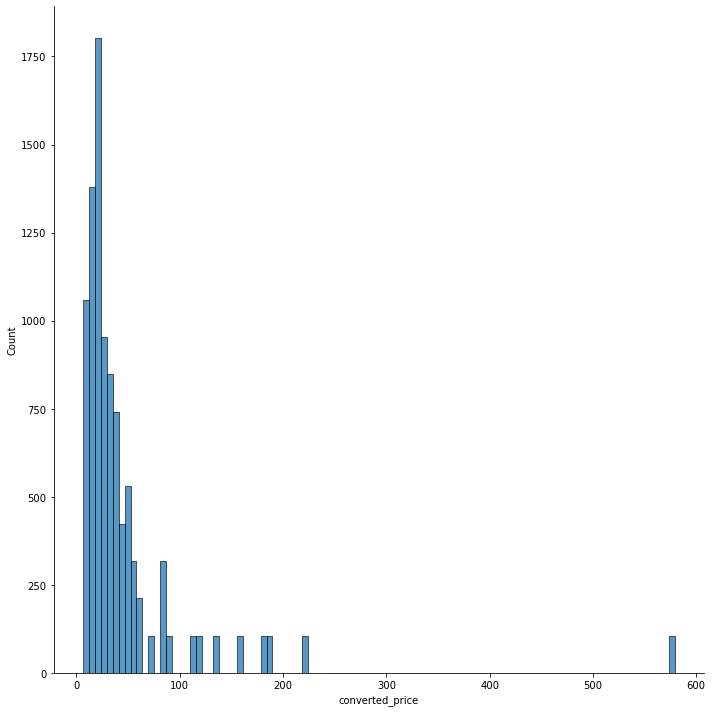

In [37]:
sns.displot(df.converted_price, height=10,aspect=1, bins=100)
plt.show();

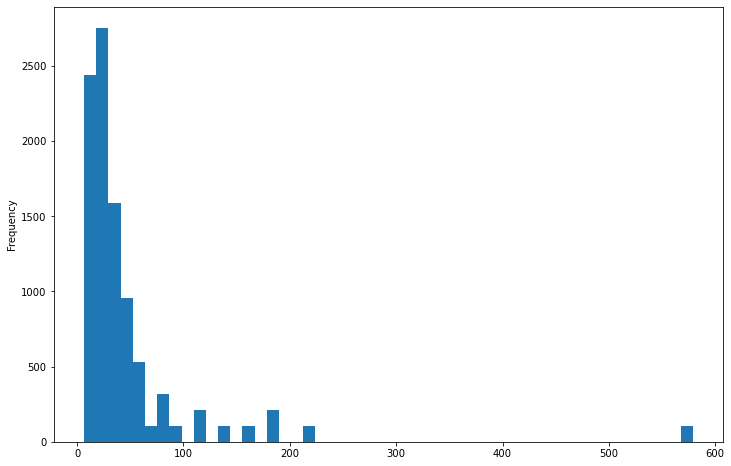

In [38]:
df.converted_price.plot.hist(figsize=(12,8), bins=50)
plt.show();

In [68]:
df.drop_duplicates(subset=['title', 'galleryURL'], keep='first')

,title,galleryURL,viewItemURL,postalCode,price_in_US,shipping_cost,converted_price,benchmade,buck,case,crkt,kershaw,leatherman,spyderco,victorinox,Binary_Target,profit,ROI
0,victorinox classic sd mini swiss army pocket k...,https://i.ebayimg.com/thumbs/images/g/smEAAOSw...,https://www.ebay.com/itm/Victorinox-Classic-SD...,228**,7.25,3.50,10.75,0.0,0.0,0.0,0.0,0.0,0.0,0.0,20.0,False,-9.25,-46.250000
2,victorinox classic sd swiss army knife 3 tool ...,https://i.ebayimg.com/thumbs/images/g/3f4AAOSw...,https://www.ebay.com/itm/Victorinox-Classic-SD...,303**,8.53,0.00,8.53,0.0,0.0,0.0,0.0,0.0,0.0,0.0,20.0,False,-11.47,-57.350000
3,crkt drifter folding knife,https://i.ebayimg.com/thumbs/images/g/u8gAAOSw...,https://www.ebay.com/itm/CRKT-Drifter-Folding-...,786**,16.99,2.99,19.98,0.0,0.0,0.0,15.0,0.0,0.0,0.0,0.0,False,4.98,33.200000
4,spyderco ladybug lockback pocket knife seki japan,https://i.ebayimg.com/thumbs/images/g/JowAAOSw...,https://www.ebay.com/itm/Spyderco-Ladybug-Lock...,472**,36.00,0.00,36.00,0.0,0.0,0.0,0.0,0.0,0.0,30.0,0.0,False,6.00,20.000000
5,spyderco grasshopper folding pocket knife,https://i.ebayimg.com/thumbs/images/g/KpQAAOSw...,https://www.ebay.com/itm/Spyderco-Grasshopper-...,472**,16.00,0.00,16.00,0.0,0.0,0.0,0.0,0.0,0.0,30.0,0.0,False,-14.00,-46.666667
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
87,crkt li'l guppie 9075 knife,https://i.ebayimg.com/thumbs/images/g/5E4AAOSw...,https://www.ebay.com/itm/Crkt-Lil-Guppie-9075-...,472**,32.00,0.00,32.00,0.0,0.0,0.0,15.0,0.0,0.0,0.0,0.0,True,17.00,113.333333
88,kershaw usa 1660 leek assisted opening pocket ...,https://i.ebayimg.com/thumbs/images/g/DacAAOSw...,https://www.ebay.com/itm/Kershaw-USA-1660-Leek...,626**,30.00,8.50,38.50,0.0,0.0,0.0,0.0,15.0,0.0,0.0,0.0,True,23.50,156.666667
89,kershaw assisted opening zing 1730ss folding p...,https://i.ebayimg.com/thumbs/images/g/6fIAAOSw...,https://www.ebay.com/itm/Kershaw-Assisted-Open...,711**,20.99,0.00,20.99,0.0,0.0,0.0,0.0,15.0,0.0,0.0,0.0,False,5.99,39.933333
90,lightly used benchmade 535 bugout folding knife,https://i.ebayimg.com/thumbs/images/g/6b8AAOSw...,https://www.ebay.com/itm/Lightly-Used-Benchmad...,360**,125.00,8.00,133.00,45.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,True,88.00,195.555556


In [65]:
df.drop_duplicates(subset=['galleryURL'], keep='first')

,title,galleryURL,viewItemURL,postalCode,price_in_US,shipping_cost,converted_price,benchmade,buck,case,crkt,kershaw,leatherman,spyderco,victorinox,Binary_Target,profit,ROI
0,victorinox classic sd mini swiss army pocket k...,https://i.ebayimg.com/thumbs/images/g/smEAAOSw...,https://www.ebay.com/itm/Victorinox-Classic-SD...,228**,7.25,3.50,10.75,0.0,0.0,0.0,0.0,0.0,0.0,0.0,20.0,False,-9.25,-46.250000
2,victorinox classic sd swiss army knife 3 tool ...,https://i.ebayimg.com/thumbs/images/g/3f4AAOSw...,https://www.ebay.com/itm/Victorinox-Classic-SD...,303**,8.53,0.00,8.53,0.0,0.0,0.0,0.0,0.0,0.0,0.0,20.0,False,-11.47,-57.350000
3,crkt drifter folding knife,https://i.ebayimg.com/thumbs/images/g/u8gAAOSw...,https://www.ebay.com/itm/CRKT-Drifter-Folding-...,786**,16.99,2.99,19.98,0.0,0.0,0.0,15.0,0.0,0.0,0.0,0.0,False,4.98,33.200000
4,spyderco ladybug lockback pocket knife seki japan,https://i.ebayimg.com/thumbs/images/g/JowAAOSw...,https://www.ebay.com/itm/Spyderco-Ladybug-Lock...,472**,36.00,0.00,36.00,0.0,0.0,0.0,0.0,0.0,0.0,30.0,0.0,False,6.00,20.000000
5,spyderco grasshopper folding pocket knife,https://i.ebayimg.com/thumbs/images/g/KpQAAOSw...,https://www.ebay.com/itm/Spyderco-Grasshopper-...,472**,16.00,0.00,16.00,0.0,0.0,0.0,0.0,0.0,0.0,30.0,0.0,False,-14.00,-46.666667
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
87,crkt li'l guppie 9075 knife,https://i.ebayimg.com/thumbs/images/g/5E4AAOSw...,https://www.ebay.com/itm/Crkt-Lil-Guppie-9075-...,472**,32.00,0.00,32.00,0.0,0.0,0.0,15.0,0.0,0.0,0.0,0.0,True,17.00,113.333333
88,kershaw usa 1660 leek assisted opening pocket ...,https://i.ebayimg.com/thumbs/images/g/DacAAOSw...,https://www.ebay.com/itm/Kershaw-USA-1660-Leek...,626**,30.00,8.50,38.50,0.0,0.0,0.0,0.0,15.0,0.0,0.0,0.0,True,23.50,156.666667
89,kershaw assisted opening zing 1730ss folding p...,https://i.ebayimg.com/thumbs/images/g/6fIAAOSw...,https://www.ebay.com/itm/Kershaw-Assisted-Open...,711**,20.99,0.00,20.99,0.0,0.0,0.0,0.0,15.0,0.0,0.0,0.0,False,5.99,39.933333
90,lightly used benchmade 535 bugout folding knife,https://i.ebayimg.com/thumbs/images/g/6b8AAOSw...,https://www.ebay.com/itm/Lightly-Used-Benchmad...,360**,125.00,8.00,133.00,45.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,True,88.00,195.555556


In [71]:
df[df.duplicated(keep=False, subset='title')].sort_values(by='title')

,title,galleryURL,viewItemURL,postalCode,price_in_US,shipping_cost,converted_price,benchmade,buck,case,crkt,kershaw,leatherman,spyderco,victorinox,Binary_Target,profit,ROI
6724,"1600 kershaw chive knife plain blade 3"" frame ...",https://i.ebayimg.com/thumbs/images/g/SfoAAOSw...,https://www.ebay.com/itm/1600-Kershaw-Chive-Kn...,488**,27.99,0.0,27.99,0.0,0.0,0.0,0.0,15.0,0.0,0.0,0.0,True,12.99,86.600000
9363,"1600 kershaw chive knife plain blade 3"" frame ...",https://i.ebayimg.com/thumbs/images/g/SfoAAOSw...,https://www.ebay.com/itm/1600-Kershaw-Chive-Kn...,488**,27.99,0.0,27.99,0.0,0.0,0.0,0.0,15.0,0.0,0.0,0.0,True,12.99,86.600000
809,"1600 kershaw chive knife plain blade 3"" frame ...",https://i.ebayimg.com/thumbs/images/g/SfoAAOSw...,https://www.ebay.com/itm/1600-Kershaw-Chive-Kn...,488**,27.99,0.0,27.99,0.0,0.0,0.0,0.0,15.0,0.0,0.0,0.0,True,12.99,86.600000
3266,"1600 kershaw chive knife plain blade 3"" frame ...",https://i.ebayimg.com/thumbs/images/g/SfoAAOSw...,https://www.ebay.com/itm/1600-Kershaw-Chive-Kn...,488**,27.99,0.0,27.99,0.0,0.0,0.0,0.0,15.0,0.0,0.0,0.0,True,12.99,86.600000
8817,"1600 kershaw chive knife plain blade 3"" frame ...",https://i.ebayimg.com/thumbs/images/g/SfoAAOSw...,https://www.ebay.com/itm/1600-Kershaw-Chive-Kn...,488**,27.99,0.0,27.99,0.0,0.0,0.0,0.0,15.0,0.0,0.0,0.0,True,12.99,86.600000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4808,vtg kershaw kai 5300 seki japan gentleman ns p...,https://i.ebayimg.com/thumbs/images/g/mZoAAOSw...,https://www.ebay.com/itm/Vtg-Kershaw-Kai-5300-...,838**,26.95,0.0,26.95,0.0,0.0,0.0,0.0,15.0,0.0,0.0,0.0,True,11.95,79.666667
9449,vtg kershaw kai 5300 seki japan gentleman ns p...,https://i.ebayimg.com/thumbs/images/g/mZoAAOSw...,https://www.ebay.com/itm/Vtg-Kershaw-Kai-5300-...,838**,26.95,0.0,26.95,0.0,0.0,0.0,0.0,15.0,0.0,0.0,0.0,True,11.95,79.666667
5081,vtg kershaw kai 5300 seki japan gentleman ns p...,https://i.ebayimg.com/thumbs/images/g/mZoAAOSw...,https://www.ebay.com/itm/Vtg-Kershaw-Kai-5300-...,838**,26.95,0.0,26.95,0.0,0.0,0.0,0.0,15.0,0.0,0.0,0.0,True,11.95,79.666667
2169,vtg kershaw kai 5300 seki japan gentleman ns p...,https://i.ebayimg.com/thumbs/images/g/mZoAAOSw...,https://www.ebay.com/itm/Vtg-Kershaw-Kai-5300-...,838**,26.95,0.0,26.95,0.0,0.0,0.0,0.0,15.0,0.0,0.0,0.0,True,11.95,79.666667


In [39]:
df.to_csv("data/full_dataset2.csv")

In [ ]:
display(df['price_in_US'].describe())
sns.boxplot(x=df['price_in_US'])
plt.show();

In [ ]:
Q1 = df['price_in_US'].quantile(.25)
Q3 = df['price_in_US'].quantile(.75)
IQR = Q3 - Q1

In [ ]:
lower_lim = Q1 - 1.5*IQR
upper_lim = Q3 + 1.5*IQR

In [ ]:
lower_lim

In [ ]:
upper_lim

In [ ]:
df

In [ ]:
df = df.loc[(df['price_in_US'] > lower_lim ) & (df['price_in_US'] < upper_lim)]

In [ ]:
display(df['price_in_US'].describe())
sns.boxplot(x=df['price_in_US'])
plt.show();

In [ ]:
sns.displot(df.price_in_US, height=10,aspect=1, bins=50)
plt.show();

In [ ]:
df.price_in_US.value_counts(ascending=True)

In [ ]:
# import glob
# import os


# path = r'C:\Users\12108\Desktop\ebay_knife_data\dsc-5-capstone-project\surplusStore'                     # use your path
# all_files = glob.glob(os.path.join(path, "*.csv"))     # advisable to use os.path.join as this makes concatenation OS independent

# df_from_each_file = (pd.read_csv(f) for f in all_files)
# concatenated_df   = pd.concat(df_from_each_file, ignore_index=True)

# concatenated_df.head()

# concatenated_df.fillna(0, inplace=True)

# concatenated_df.info()

# concatenated_df.to_csv('surplusStore/workingDataFrame2.csv')

In [ ]:
df.isna().sum()

## THIS CALL TO THE WEBSITE RETURNED NO SOG KNIVES OR CRKT KNIVES
## MUST MAKE SEPERATE CALLS
## NOT SHOWN IN THIS NOTEBOOK 

In [ ]:


df_crkt = pd.read_csv('data/full_dataset_CRKT.csv')
df_sog = pd.read_csv('data/full_dataset_SOG.csv')



# df_SOG.info()

# df_SOG['sog'] = 1.0
# df_SOG['sog'] = 1.0

# mkdir surplusStore

# df_surplus.to_csv('surplusStore/workingDataFrame.csv', index=False)
# df_CRKT.to_csv('surplusStore/df_CRKT.csv', index=False)
# df_SOG.to_csv('surplusStore/df_SOG.csv', index=False)

# df_surplus.head()

# Data Science Processes

## Introduction

As discussed, this section is all about synthesizing your skills in order to work through a full Data Science workflow. In this lesson, you'll take a look at some general outlines for how Data Scientists organize their workflow and conceptualize their process.

## Objectives

You will be able to:

- List the different data science process frameworks
- Compare and contrast popular data science process frameworks such as CRISP-DM, KDD, OSEMN


## What is a Data Science Process?

Data Science projects are often complex, with many stakeholders, data sources, and goals. Due to this, the Data Science community has created several methodologies for helping organize and structure Data Science Projects.  In this lesson, you'll explore three of the most popular methodologies -- **_CRISP-DM_**, **_KDD_**, and **_OSEMN_**, and explore how you can make use of them to keep your projects well-structured and organized. 

## CRoss-Industry Standard Process for Data Mining (CRISP-DM)

<img src="https://raw.githubusercontent.com/learn-co-curriculum/dsc-data-science-processes/master/images/new_crisp-dm.png" width="500">

**_CRISP-DM_** is probably the most popular Data Science process in the Data Science world right now. Take a look at the visualization above to get a feel for CRISP-DM. Notice that CRISP-DM is an iterative process!

Let's take a look at the individual steps involved in CRISP-DM.

**_Business Understanding:_**  This stage is all about gathering facts and requirements. Who will be using the model you build? How will they be using it? How will this help the goals of the business or organization overall? Data Science projects are complex, with many moving parts and stakeholders. They're also time intensive to complete or modify. Because of this, it is very important that the Data Science team working on the project has a deep understanding of what the problem is, and how the solution will be used. Consider the fact that many stakeholders involved in the project may not have technical backgrounds, and may not even be from the same organization.  Stakeholders from one part of the organization may have wildly different expectations about the project than stakeholders from a different part of the organization -- for instance, the sales team may be under the impression that a recommendation system project is meant to increase sales by recommending upsells to current customers, while the marketing team may be under the impression that the project is meant to help generate new leads by personalizing product recommendations in a marketing email. These are two very different interpretations of a recommendation system project, and it's understandable that both departments would immediately assume that the primary goal of the project is one that helps their organization. As a Data Scientist, it's up to you to clarify the requirements and make sure that everyone involved understands what the project is and isn't. 

During this stage, the goal is to get everyone on the same page and to provide clarity on the scope of the project for everyone involved, not just the Data Science team. Generate and answer as many contextual questions as you can about the project. 

Good questions for this stage include:

- Who are the stakeholders in this project? Who will be directly affected by the creation of this project?
- What business problem(s) will this Data Science project solve for the organization?  
- What problems are inside the scope of this project?
- What problems are outside the scope of this project?
- What data sources are available to us?
- What is the expected timeline for this project? Are there hard deadlines (e.g. "must be live before holiday season shopping") or is this an ongoing project?
- Do stakeholders from different parts of the company or organization all have the exact same understanding about what this project is and isn't?

**_Data Understanding:_**

Once we have a solid understanding of the business implications for this project, we move on to understanding our data. During this stage, we'll aim to get a solid understanding of the data needed to complete the project.  This step includes both understanding where our data is coming from, as well as the information contained within the data. 

Consider the following questions when working through this stage:

- What data is available to us? Where does it live? Do we have the data, or can we scrape/buy/source the data from somewhere else?
- Who controls the data sources, and what steps are needed to get access to the data?
- What is our target?
- What predictors are available to us?
- What data types are the predictors we'll be working with?
- What is the distribution of our data?
- How many observations does our dataset contain? Do we have a lot of data? Only a little? 
- Do we have enough data to build a model? Will we need to use resampling methods?
- How do we know the data is correct? How is the data collected? Is there a chance the data could be wrong?

**_Data Preparation:_**

Once we have a strong understanding of our data, we can move onto preparing the data for our modeling steps. 

During this stage, we'll want to handle the following issues:

- Detecting and dealing with missing values
- Data type conversions (e.g. numeric data mistakenly encoded as strings)
- Checking for and removing multicollinearity (correlated predictors)
- Normalizing our numeric data
- Converting categorical data to numeric format through one-hot encoding

**_Modeling:_**

Once we have clean data, we can begin modeling! Remember, modeling, as with any of these other steps, is an iterative process. During this stage, we'll try to build and tune models to get the highest performance possible on our task. 

Consider the following questions during the modeling step:

- Is this a classification task? A regression task? Something else?
- What models will we try?
- How do we deal with overfitting?
- Do we need to use regularization or not?
- What sort of validation strategy will we be using to check that our model works well on unseen data?
- What loss functions will we use?
- What threshold of performance do we consider as successful?

**_Evaluation:_**

During this step, we'll evaluate the results of our modeling efforts. Does our model solve the problems that we outlined all the way back during step 1? Why or why not? Often times, evaluating the results of our modeling step will raise new questions, or will cause us to consider changing our approach to the problem.  Notice from the CRISP-DM diagram above, that the "Evaluation" step is unique in that it points to both _Business Understanding_ and _Deployment_.  As we mentioned before, Data Science is an iterative process -- that means that given the new information our model has provided, we'll often want to start over with another iteration, armed with our newfound knowledge! Perhaps the results of our model showed us something important that we had originally failed to consider the goal of the project or the scope.  Perhaps we learned that the model can't be successful without more data, or different data. Perhaps our evaluation shows us that we should reconsider our approach to cleaning and structuring the data, or how we frame the project as a whole (e.g. realizing we should treat the problem as a classification rather than a regression task). In any of these cases, it is totally encouraged to revisit the earlier steps.  

Of course, if the results are satisfactory, then we instead move onto deployment!

**_Deployment:_**

During this stage, we'll focus on moving our model into production and automating as much as possible. Everything before this serves as a proof-of-concept or an investigation.  If the project has proved successful, then you'll work with stakeholders to determine the best way to implement models and insights.  For example, you might set up an automated ETL (Extract-Transform-Load) pipelines of raw data in order to feed into a database and reformat it so that it is ready for modeling. During the deployment step, you'll actively work to determine the best course of action for getting the results of your project into the wild, and you'll often be involved with building everything needed to put the software into production. 

This is one of the most rewarding steps of the entire Data Science process -- getting to see your work go live!

## Knowledge Discovery in Databases

<img src="https://raw.githubusercontent.com/learn-co-curriculum/dsc-data-science-processes/master/images/new_kdd.png" width="800">

**_Knowledge Discovery in Databases_**, or **_KDD_** is considered the oldest Data Science process. The creation of this process is credited to Gregory Piatetsky-Shapiro, who also runs the ever-popular Data Science blog, [kdnuggets](https://www.kdnuggets.com/). If you're interested, read the original white paper on KDD, which can be found [here](https://www.kdnuggets.com/gpspubs/aimag-kdd-overview-1992.pdf)!

The KDD process is quite similar to the CRISP-DM process. The diagram above illustrates every step of the KDD process, as well as the expected output at each stage. 

**_Selection_**:

During this stage, you'll focus on selecting your problem, and the data that will help you answer it. This stage works much like the first stage of CRISP-DM -- you begin by focusing on developing an understanding of the domain the problem resides in (e.g. marketing, finance, increasing customer sales, etc), the previous work done in this domain, and the goals of the stakeholders involved with the process.  

Once you've developed a strong understanding of the goals and the domain, you'll work to establish where your data is coming from, and which data will be useful to you.  Organizations and companies usually have a ton of data, and only some of it will be relevant to the problem you're trying to solve.  During this stage, you'll focus on examining the data sources available to you and gathering the data that you deem useful for the project.  

The output of this stage is the dataset you'll be using for the Data Science project. 

**_Preprocessing_**:

The preprocessing stage is pretty straightforward -- the goal of this stage is to "clean" the data by preprocessing it.  For text data, this may include things like tokenization.  You'll also identify and deal with issues like outliers and/or missing data in this stage.  

In practice, this stage often blurs with the _Transformation_ stage. 

The output of this stage is preprocessed data that is more "clean" than it was at the start of this stage -- although the dataset is not quite ready for modeling yet. 

**_Transformation_**:

During this stage, you'll take your preprocessed data and transform it in a way that makes it more ideal for modeling.  This may include steps like feature engineering and dimensionality reduction.  At this stage, you'll also deal with things like checking for and removing multicollinearity from the dataset. Categorical data should also be converted to numeric format through one-hot encoding during this step.

The output of this stage is a dataset that is now ready for modeling. All null values and outliers are removed, categorical data has been converted to a format that a model can work with, and the dataset is generally ready for experimentation with modeling.  

**_Data Mining_**:

The Data Mining stage refers to using different modeling techniques to try and build a model that solves the problem we're after -- often, this is a classification or regression task. During this stage, you'll also define your parameters for given models, as well as your overall criteria for measuring the performance of a model.  

You may be wondering what Data Mining is, and how it relates to Data Science. In practice, it's just an older term that essentially means the same thing as Data Science. Dr. Piatetsky-Shapiro defines Data Mining as "the non-trivial extraction of implicit, previously unknown and potentially useful information from data."  Making of things such as Machine Learning algorithms to find insights in large datasets that aren't immediately obvious without these algorithms is at the heart of the concept of Data Mining, just as it is in Data Science. In a pragmatic sense, this is why the terms Data Mining and Data Science are typically used interchangeably, although the term Data Mining is considered an older term that isn't used as often nowadays. 

The output of this stage results from a fit to the data for the problem we're trying to solve.  

**_Interpretation/Evaluation_**:

During this final stage of KDD, we focus on interpreting the "patterns" discovered in the previous step to help us make generalizations or predictions that help us answer our original question. During this stage, you'll consolidate everything you've learned to present it to stakeholders for guiding future actions. Your output may be a presentation that you use to communicate to non-technical managers or executives (never discount the importance of knowing PowerPoint as a Data Scientist!).  Your conclusions for a project may range from "this approach didn't work" or "we need more data about {X}" to "this is ready for production, let's build it!".  

## OSEMN

<img src="https://raw.githubusercontent.com/learn-co-curriculum/dsc-data-science-processes/master/images/new_osemn.png" width="800">
<a href="https://www.kdnuggets.com/2018/02/data-science-command-line-book-exploring-data.html" target="_blank">Adapted from: KDNuggets</a>

This brings us to the Data Science process we'll be using during this section -- OSEMN (sometimes referred as OSEMiN, and pronounced "OH-sum", rhymes with "possum"). This is the most straightforward of the Data Science processes discussed so far. Note that during this process, just like the others, the stages often blur together. It is completely acceptable (and often a best practice!) to float back and forth between stages as you learn new things about your problem, dataset, requirements, etc.  It's quite common to get to the modeling step and realize that you need to scrub your data a bit more or engineer a different feature and jump back to the "Scrub" stage, or go all the way back to the "Obtain" stage when you realize your current data isn't sufficient to solve this problem. As with any of these frameworks, OSEMN is meant to be treated more like a set of guidelines for structuring your project than set-in-stone steps that cannot be violated.  

**_Obtain_**:

As with CRISP-DM and KDD, this step involves understanding stakeholder requirements, gathering information on the problem, and finally, sourcing data that we think will be necessary for solving this problem. 

**_Scrub_**:

During this stage, we'll focus on preprocessing our data.  Important steps such as identifying and removing null values, dealing with outliers, normalizing data, and feature engineering/feature selection are handled around this stage.  The line with this stage really blurs with the _Explore_ stage, as it is common to only realize that certain columns require cleaning or preprocessing as a result of the visualizations and explorations done during Step 3.  

Note that although technically, categorical data should be one-hot encoded during this step, in practice, it's usually done after data exploration.  This is because it is much less time-consuming to visualize and explore a few columns containing categorical data than it is to explore many different dummy columns that have been one-hot encoded. 

**_Explore_**:

This step focuses on getting to know the dataset you're working with. As mentioned above, this step tends to blend with the _Scrub_ step mentioned above.  During this step, you'll create visualizations to really get a feel for your dataset.  You'll focus on things such as understanding the distribution of different columns, checking for multicollinearity, and other tasks like that.  If your project is a classification task, you may check the balance of the different classes in your dataset.  If your problem is a regression task, you may check that the dataset meets the assumptions necessary for a regression task.  

At the end of this step, you should have a dataset ready for modeling that you've thoroughly explored and are extremely familiar with.  

**_Model_**:

This step, as with the last two frameworks, is also pretty self-explanatory. It consists of building and tuning models using all the tools you have in your data science toolbox.  In practice, this often means defining a threshold for success, selecting machine learning algorithms to test on the project, and tuning the ones that show promise to try and increase your results.  As with the other stages, it is both common and accepted to realize something, jump back to a previous stage like _Scrub_ or _Explore_, and make some changes to see how it affects the model.  

**_Interpret_**:

During this step, you'll interpret the results of your model(s), and communicate results to stakeholders.  As with the other frameworks, communication is incredibly important! During this stage, you may come to realize that further investigation is needed, or more data.  That's totally fine -- figure out what's needed, go get it, and start the process over! If your results are satisfactory to all stakeholders involved, you may also go from this stage right into putting your model into production and automating processes necessary to support it.  


## A Note On Communicating Results

Regardless of the quality of your results, it's very important that you be aware of the business requirements and stakeholder expectations at all times! Generally, no matter which of the above processes you use, you'll communicate your results in a two-pronged manner: 

- A short, high-level presentation covering your question, process, and results meant for non-technical audiences
- A detailed Jupyter Notebook demonstrating your entire process meant for technical audiences

In general, you can see why Data Scientists love Jupyter Notebooks! It is very easy to format results in a reproducible, easy-to-understand way.  Although a detailed Jupyter Notebook may seem like the more involved of the two deliverables listed above, the high-level presentation is often the hardest! Just remember -- even if the project took you/your team over a year and utilized the most cutting-edge machine learning techniques available, you still need to be able to communicate your results in about 5 slides (using graphics, not words, whenever possible!), in a 5 minute presentation in a way that someone that can't write code can still understand and be convinced by!


## Conclusion

In this lesson, you learned about the different data science process frameworks including CRISP-DM, KDD, and OSEMN. You also learned that the data science process is iterative and that a typical data science project involves many different stakeholders who may not have a technical background. As such, it's important to recognize that data scientists must be able to communicate their findings in a non-technical way.